In [3]:
import os
import cv2 as cv

from matplotlib import pyplot as plt
from pathlib import Path

In [4]:
IMAGES_PATH = Path('Kvasir-SEG') / 'images'
MASKS_PATH = Path('Kvasir-SEG') / 'masks'

In [5]:
images_files = os.listdir(IMAGES_PATH)
masks_files = os.listdir(MASKS_PATH)

In [6]:
def show_img(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

In [165]:
SIZE = 200


def read_img_and_mask(index):
    img = cv.imread(str(IMAGES_PATH / images_files[index]))
    resized_img = cv.resize(img, (SIZE, SIZE))
    msk = cv.imread(str(MASKS_PATH / masks_files[index]), 0)
    resized_msk = cv.resize(msk, (SIZE, SIZE))

    return resized_img, resized_msk

In [169]:
def show_img_width_msk(img, msk, color=[255, 0, 0]):
    edge = cv.Canny(msk, 30, 100)
    img[edge == 255] = color
    show_img(img)

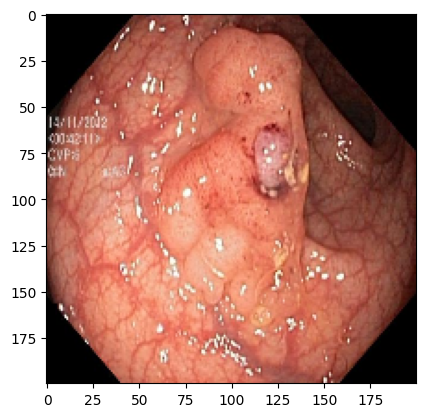

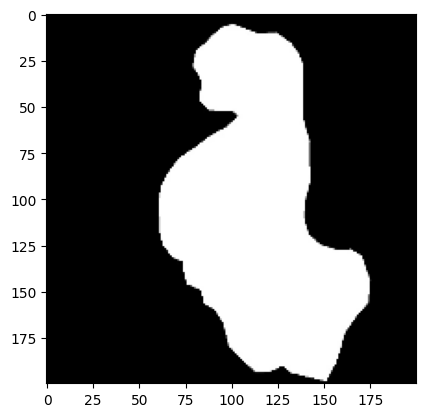

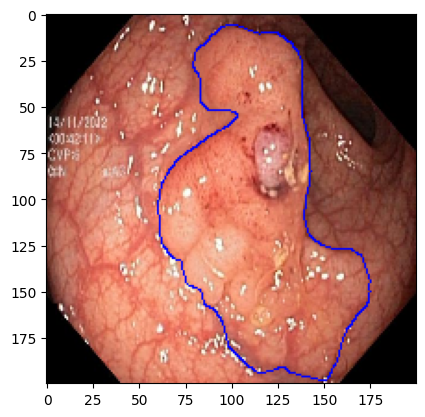

In [170]:
img, msk = read_img_and_mask(2)
show_img(img)
show_img(msk)
show_img_width_msk(img, msk)